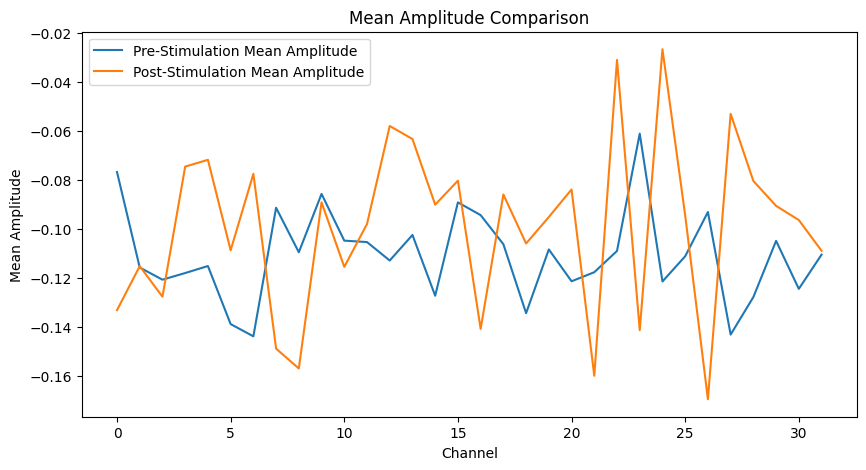

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
savename = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/human-cortical-organoid-signal-analysis/experiment_data/exp_240213_151732_all_data.npz'
data = np.load(savename)
amp_data = data['amp_data']  # Amplifier data
stim_data = data['stim_data']  # Stimulation data

# Identify first stimulation points and split data
first_stim_points = []
amp_data_pre_stim = []
amp_data_post_stim = []

for i in range(stim_data.shape[0]):  # Assuming stim_data.shape[0] is 8 for stimulation channels
    # Find the first non-zero (assuming zero is no stimulation) in the stim channel
    stim_onset = np.where(stim_data[i] != 0)[0][0] if np.any(stim_data[i] != 0) else -1
    first_stim_points.append(stim_onset)
    
    # Split amp data based on stim_onset
    if stim_onset != -1:  # If there's stimulation
        amp_data_pre_stim.append(amp_data[:, :stim_onset])  # All amp channels up to stimulation
        amp_data_post_stim.append(amp_data[:, stim_onset:])  # All amp channels from stimulation onwards
    else:
        amp_data_pre_stim.append(None)
        amp_data_post_stim.append(None)

# Now, you have:
# - first_stim_points: list of first stimulation points for each stim channel
# - amp_data_pre_stim, amp_data_post_stim: lists of amp data segments before and after first stim

# Example analysis: Compare mean amplitude before and after stimulation for the first stim channel
if first_stim_points[0] != -1:  # Ensure there was a stimulation point
    mean_amp_pre_stim = np.mean(amp_data_pre_stim[0], axis=1)  # Mean across time, for each channel
    mean_amp_post_stim = np.mean(amp_data_post_stim[0], axis=1)  # Mean across time, for each channel

    # Simple comparison plot for the first stimulation channel
    plt.figure(figsize=(10, 5))
    plt.plot(mean_amp_pre_stim, label='Pre-Stimulation Mean Amplitude')
    plt.plot(mean_amp_post_stim, label='Post-Stimulation Mean Amplitude')
    plt.xlabel('Channel')
    plt.ylabel('Mean Amplitude')
    plt.title('Mean Amplitude Comparison')
    plt.legend()
    plt.show()

### Higuchi Fractal Dimension

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
savename = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/human-cortical-organoid-signal-analysis/experiment_data/exp_240213_151732_all_data.npz'
data = np.load(savename)
amp_data = data['amp_data']  # Amplifier data
stim_data = data['stim_data']  # Stimulation data

# Function to calculate the Higuchi Fractal Dimension (HFD)
def higuchi_fractal_dimension(data, kmax=10):
    L = []
    x = np.arange(1, kmax + 1)
    N = len(data)
    
    for k in range(1, kmax + 1):
        Lk = 0
        for m in range(k):
            len_min = min(len(data[m::k]), len(data[m+k::k]))
            lm = np.sum(np.abs(data[m::k][:len_min] - data[m+k::k][:len_min])) / ((N - 1) // k) / k
            Lk += lm
        Lk /= k
        L.append(Lk)
    
    L = np.array(L)
    log_n = -np.log(np.divide(x, N, where=x!=0))
    log_L = np.log(L)
    
    hfd, _ = np.polyfit(log_n, log_L, 1)
    return hfd

# Initialize necessary lists
amp_data_pre_stim = []
amp_data_post_stim = []
first_stim_points = []

# Assuming stim_data and amp_data are correctly populated with your data

for i in range(stim_data.shape[0]):  # Process each stimulation channel
    stim_onset = np.where(stim_data[i] != 0)[0][0] if np.any(stim_data[i] != 0) else -1
    first_stim_points.append(stim_onset)
    
    if stim_onset != -1:  # If there's stimulation
        amp_data_pre_stim.append(amp_data[:, :stim_onset])
        amp_data_post_stim.append(amp_data[:, stim_onset:])
    else:
        amp_data_pre_stim.append(None)
        amp_data_post_stim.append(None)

# Convert to NumPy arrays for easier processing
amp_data_pre_stim = [x for x in amp_data_pre_stim if x is not None]  # Filter out None values
amp_data_post_stim = [x for x in amp_data_post_stim if x is not None]  # Filter out None values

# Convert lists to NumPy arrays
amp_data_pre_stim = np.array(amp_data_pre_stim)
amp_data_post_stim = np.array(amp_data_post_stim)

# Calculate HFD for each channel
# Assuming hfd_pre_stim and hfd_post_stim have the same length
num_channels = len(hfd_pre_stim)  # Use actual number of channels

# Calculate the subplot grid dimensions
num_rows = num_channels // 4 if num_channels % 4 == 0 else num_channels // 4 + 1

fig, axs = plt.subplots(num_rows, 4, figsize=(20, 5*num_rows))
fig.suptitle('Higuchi Fractal Dimension Across Channels')

for i in range(num_channels):
    row, col = divmod(i, 4)
    ax = axs[row, col] if num_channels > 4 else axs[col]
    ax.plot([hfd_pre_stim[i], hfd_post_stim[i]], marker='o', linestyle='-')
    ax.set_title(f'Channel {i+1}')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Pre-Stim', 'Post-Stim'])
    ax.set_ylabel('HFD')

# Hide unused subplots if any
if num_channels % 4 != 0:
    for idx in range(num_channels, num_rows * 4):
        row, col = divmod(idx, 4)
        axs[row, col].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: name 'hfd_pre_stim' is not defined

### 2D Phase Space Reconstruction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import multiprocessing
import os
import zipfile
from minepy import MINE

# Define directories for storing outputs
base_dir = '/home/vincent/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/human-cortical-organoid-signal-analysis/analysis_experiments'
pre_stim_embedding_dir = os.path.join(base_dir, 'pre_stim_embedding_data')
post_stim_embedding_dir = os.path.join(base_dir, 'post_stim_embedding_data')
plots_directory = os.path.join(base_dir, 'plots')

# Ensure directories exist
for dir_path in [pre_stim_embedding_dir, post_stim_embedding_dir, plots_directory]:
    os.makedirs(dir_path, exist_ok=True)

# Load data
data = np.load('/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/human-cortical-organoid-signal-analysis/experiment_data/exp_240213_151732_all_data.npz')  # Adjust the path as necessary
amp_data = data['amp_data']  # Amplifier data
stim_data = data['stim_data']  # Stimulation data

# Identify first stimulation points and split data
first_stim_points = []
amp_data_pre_stim = []
amp_data_post_stim = []

amp_channel_names = [f'Ch {i+1}' for i in range(32)]

for i in range(stim_data.shape[0]):  # Assuming stim_data.shape[0] is 8 for stimulation channels
    # Find the first non-zero (assuming zero is no stimulation) in the stim channel
    stim_onset = np.where(stim_data[i] != 0)[0][0] if np.any(stim_data[i] != 0) else -1
    first_stim_points.append(stim_onset)
    
    # Split amp data based on stim_onset
    if stim_onset != -1:  # If there's stimulation
        amp_data_pre_stim.append(amp_data[:, :stim_onset])  # All amp channels up to stimulation
        amp_data_post_stim.append(amp_data[:, stim_onset:])  # All amp channels from stimulation onwards
    else:
        amp_data_pre_stim.append(None)
        amp_data_post_stim.append(None)

# Now, you have:
# - first_stim_points: list of first stimulation points for each stim channel
# - amp_data_pre_stim, amp_data_post_stim: lists of amp data segments before and after first stim

def mutual_info_worker(args):
    data1, data2 = args
    mine = MINE(alpha=0.6, c=15)
    # Ensure data1 and data2 are 1D. If not, this needs adjustment.
    if data1.ndim > 1:
        data1 = data1.ravel()
    if data2.ndim > 1:
        data2 = data2.ravel()
    mine.compute_score(data1, data2)
    return mine.mic()

def determine_delay(data, max_delay=100, subsample_factor=10):
    subsampled_data = data[::subsample_factor]
    if subsampled_data.ndim > 1:
        # Assuming we're only interested in analyzing the first feature or a specific feature across time
        subsampled_data = subsampled_data[:, 0]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        mi_values = pool.map(mutual_info_worker, [(subsampled_data[:-i], subsampled_data[i:]) for i in range(1, max_delay + 1)])
    return np.argmin(mi_values) + 1


def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i + emb_dim * delay:delay] for i in range(N - (emb_dim - 1) * delay)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)
    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data)
        distances, indices = nbrs.kneighbors(emb_data)
        false_neighbors[d - 1] = np.mean((np.abs(distances[:, 0] - distances[:, 1]) / distances[:, 1]) > R)
    return false_neighbors

# Analysis process, adapted for pre- and post-stimulation data
for i, channel_name in enumerate(amp_channel_names):
    # Pre-stim data analysis
    channel_data_pre_stim = amp_data_pre_stim[i]
    optimal_delay_pre = determine_delay(channel_data_pre_stim, max_delay=20, subsample_factor=10)
    embedded_data_pre_2d = delay_embedding(channel_data_pre_stim, 2, optimal_delay_pre)
    embedded_data_pre_3d = delay_embedding(channel_data_pre_stim, 3, optimal_delay_pre)
    
    # Save the pre-stimulation embedded data
    np.save(os.path.join(pre_stim_embedding_dir, f'2dembedded_{channel_name}.npy'), embedded_data_pre_2d)
    np.save(os.path.join(pre_stim_embedding_dir, f'3dembedded_{channel_name}.npy'), embedded_data_pre_3d)
    
    # Post-stim data analysis
    channel_data_post_stim = amp_data_post_stim[i]
    optimal_delay_post = determine_delay(channel_data_post_stim, max_delay=20, subsample_factor=10)
    embedded_data_post_2d = delay_embedding(channel_data_post_stim, 2, optimal_delay_post)
    embedded_data_post_3d = delay_embedding(channel_data_post_stim, 3, optimal_delay_post)
    
    # Save the post-stimulation embedded data
    np.save(os.path.join(post_stim_embedding_dir, f'2dembedded_{channel_name}.npy'), embedded_data_post_2d)
    np.save(os.path.join(post_stim_embedding_dir, f'3dembedded_{channel_name}.npy'), embedded_data_post_3d)

        # Generate and save plots for pre-stimulation
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data_pre_2d[:, 0], embedded_data_pre_2d[:, 1], s=1)
    plt.title(f'2D Phase Space Reconstruction for {channel_name} Pre-Stim')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(os.path.join(plots_directory, f'2D_Pre_{channel_name}.png'))
    plt.close()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedded_data_pre_3d[:, 0], embedded_data_pre_3d[:, 1], embedded_data_pre_3d[:, 2], s=1)
    ax.set_title(f'3D Phase Space Reconstruction for {channel_name} Pre-Stim')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.savefig(os.path.join(plots_directory, f'3D_Pre_{channel_name}.png'))
    plt.close()

    # Generate and save plots for post-stimulation
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data_post_2d[:, 0], embedded_data_post_2d[:, 1], s=1)
    plt.title(f'2D Phase Space Reconstruction for {channel_name} Post-Stim')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.savefig(os.path.join(plots_directory, f'2D_Post_{channel_name}.png'))
    plt.close()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedded_data_post_3d[:, 0], embedded_data_post_3d[:, 1], embedded_data_post_3d[:, 2], s=1)
    ax.set_title(f'3D Phase Space Reconstruction for {channel_name} Post-Stim')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.savefig(os.path.join(plots_directory, f'3D_Post_{channel_name}.png'))
    plt.close()


# Zip the embedded data directories
for dir_path, zip_name in [(embedding_2d_dir, '2d_embedded_data.zip'), (embedding_3d_dir, '3d_embedded_data.zip')]:
    with zipfile.ZipFile(os.path.join(base_dir, zip_name), 'w') as zipf:
        for file in os.listdir(dir_path):
            zipf.write(os.path.join(dir_path, file), file)

print("All processes completed successfully.")


TypeError: 'NoneType' object is not subscriptable

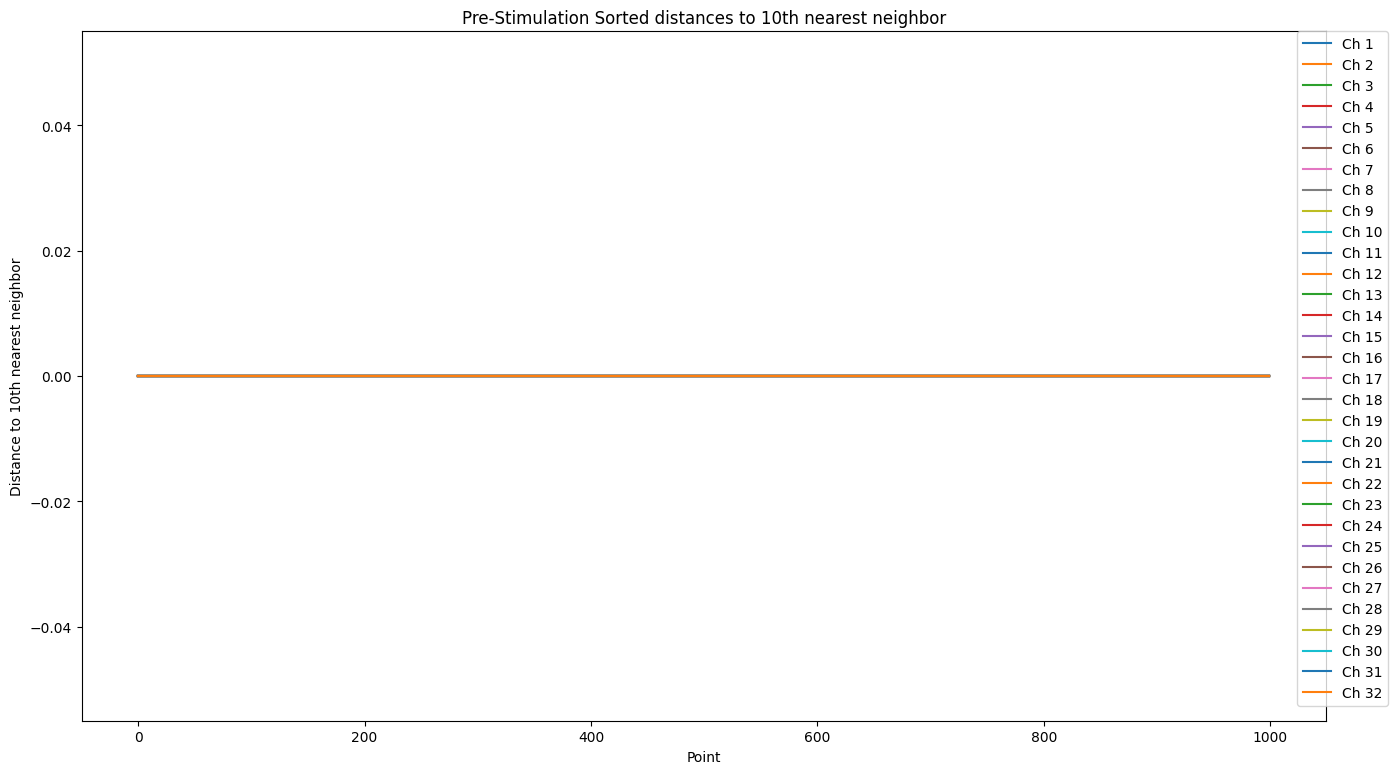

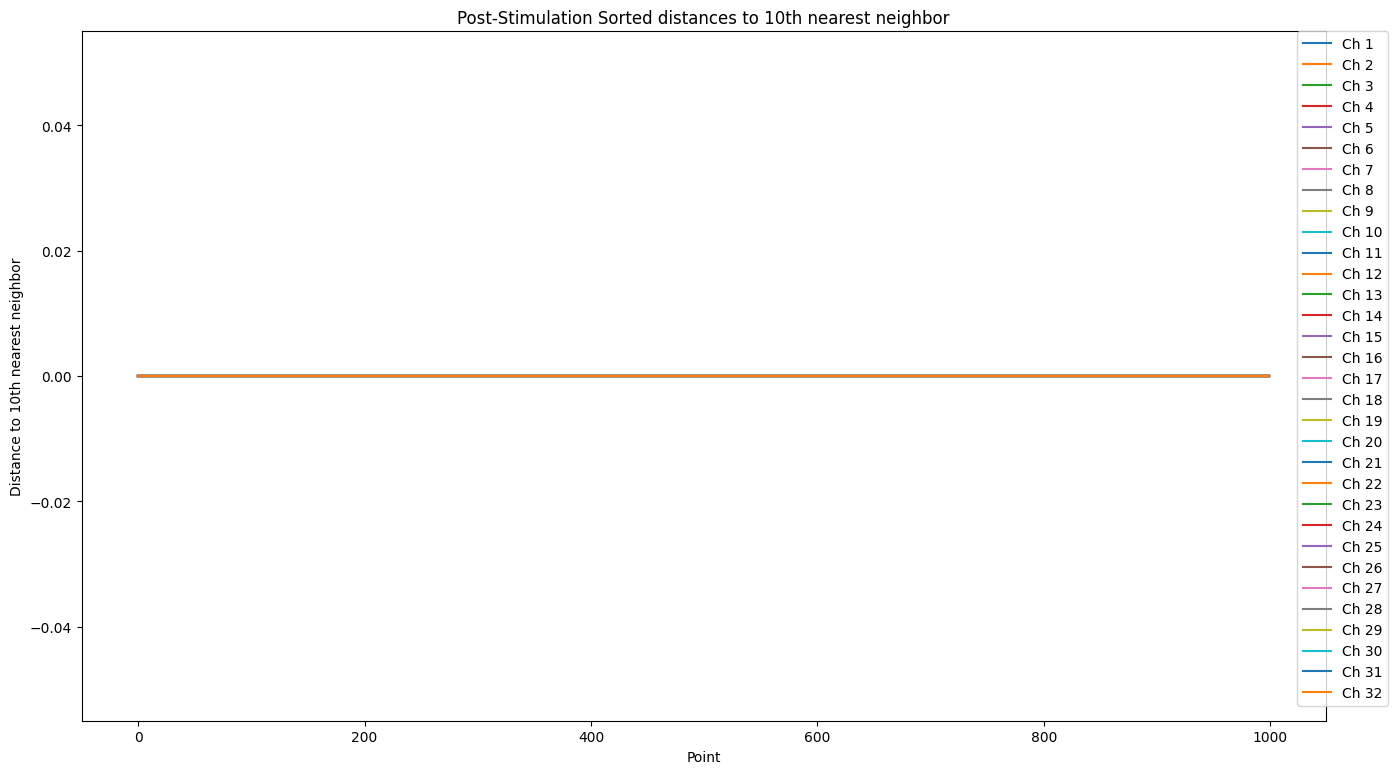

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import os

# Load your data
data_path = '/home/vincent/MySSD/JupyterProjects/AAA_projects/UnlimitedResearchCooperative/Synthetic_Intelligence_Labs/human-cortical-organoid-signal-analysis/experiment_data/exp_240213_151732_all_data.npz'
data = np.load(data_path)
amp_data = data['amp_data']  # Full amplifier data
stim_data = data['stim_data']  # Stimulation data

amp_channel_names = [f'Ch {i+1}' for i in range(32)]  # Amplifier channel names

# Identify first stimulation points and split data
first_stim_points = []
amp_data_pre_stim = []
amp_data_post_stim = []

for i in range(stim_data.shape[0]):  # Assuming stim_data.shape[0] is 8 for stimulation channels
    # Find the first non-zero (assuming zero is no stimulation) in the stim channel
    stim_onset = np.where(stim_data[i] != 0)[0][0] if np.any(stim_data[i] != 0) else -1
    first_stim_points.append(stim_onset)
    
    # Split amp data based on stim_onset
    if stim_onset != -1:  # If there's stimulation
        amp_data_pre_stim.append(amp_data[:, :stim_onset])  # All amp channels up to stimulation
        amp_data_post_stim.append(amp_data[:, stim_onset:])  # All amp channels from stimulation onwards
    else:
        amp_data_pre_stim.append(None)
        amp_data_post_stim.append(None)
        
min_samples = 10  # Define the min_samples value for nearest neighbors analysis

# Now, you have:
# - first_stim_points: list of first stimulation points for each stim channel
# - amp_data_pre_stim, amp_data_post_stim: lists of amp data segments before and after first stim

# Function to plot distances for a given dataset
def plot_distances(datasets, title):
    plt.figure(figsize=(14, 8))

    for channel_index in range(32):  # Assuming there are 32 channels
        all_distances = []  # Collect distances for all datasets for this channel

        for dataset in datasets:
            if dataset is not None:  # Check if there's data for this stimulation point
                channel_data = dataset[channel_index, :]  # Get data for the current channel
                
                # Reshape the data to have samples as rows, and features (dummy) as columns
                channel_data_reshaped = channel_data.reshape(-1, 1)
                
                # Compute nearest neighbors
                if channel_data_reshaped.shape[0] > min_samples:  # Ensure enough samples for analysis
                    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(channel_data_reshaped)
                    distances, indices = neighbors.kneighbors(channel_data_reshaped)

                    # Sort and select distances to the min_samples-th nearest neighbor
                    sorted_distances = np.sort(distances[:, min_samples-1])
                    all_distances.append(sorted_distances)

        # If distances were calculated for this channel, plot them
        if all_distances:
            # Flatten the list of arrays into a single array for plotting
            combined_distances = np.concatenate(all_distances)
            
            # Plot the sorted combined distances for the first 1000 points, if there are enough
            plt.plot(combined_distances[:1000], label=f'Ch {channel_index + 1}')

    plt.xlabel('Point')
    plt.ylabel(f'Distance to {min_samples}th nearest neighbor')
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# Plot distances for pre and post stimulation data for each of the 32 channels
plot_distances(amp_data_pre_stim, 'Pre-Stimulation Sorted distances to 10th nearest neighbor')
plot_distances(amp_data_post_stim, 'Post-Stimulation Sorted distances to 10th nearest neighbor')